<Axes: >

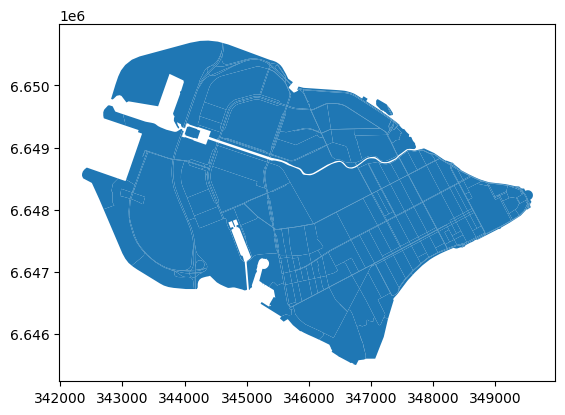

In [91]:
import geopandas as gpd
import osmnx as ox

blocks_gdf = gpd.read_parquet('./data/blocks.parquet')
query = 'Санкт Петербург, Васильевский остров'
mask_gdf = ox.features_from_place(query, tags={'boundary':'administrative'}).to_crs(blocks_gdf.crs)
blocks_gdf = blocks_gdf[blocks_gdf.intersects(mask_gdf.unary_union)]
blocks_gdf.plot()

In [ ]:
import shapely
from longsgis import voronoiDiagram4plg

BUFFER_SIZE = 1_000

def get_voronoi_polygons(blocks_gdf : gpd.GeoDataFrame, buffer_size : int):
  mask = blocks_gdf.buffer(buffer_size).unary_union
  points = {shapely.Point(coord) for block_geom in blocks_gdf.geometry for coord in block_geom.exterior.coords}
  points_gdf = gpd.GeoDataFrame(geometry=list(points), crs=blocks_gdf.crs)
  voronoi_gdf = voronoiDiagram4plg(points_gdf, mask)
  return voronoi_gdf.reset_index(drop=True)

voronoi_gdf = get_voronoi_polygons(blocks_gdf, BUFFER_SIZE)
voronoi_gdf.head()

,geometry
0,"POLYGON ((346740.083 6645513.894, 346904.061 6..."
1,"POLYGON ((346910.127 6645555.626, 346910.762 6..."
2,"POLYGON ((346745.747 6645533.815, 346755.094 6..."
3,"POLYGON ((346869.922 6645478.919, 346848.369 6..."
4,"POLYGON ((346900.012 6645584.521, 346906.616 6..."


In [ ]:
import pandas as pd

def get_grid_polygons(blocks_gdf : gpd.GeoDataFrame, voronoi_gdf : gpd.GeoDataFrame):
  gdf = pd.concat([blocks_gdf, voronoi_gdf], crs=blocks_gdf.crs)
  

In [ ]:
blocks_lines = blocks_gdf[['geometry']].copy()
blocks_lines.geometry = blocks_lines.geometry.apply(lambda g : shapely.LineString(g.exterior))
blocks_lines.head()

112    LINESTRING (346701.362 6646318.927, 346685.483...
113    LINESTRING (348111.757 6647294.345, 348082.192...
114    LINESTRING (346911.913 6645610.525, 346913.982...
115    LINESTRING (347274.278 6646250.268, 347204.988...
215    LINESTRING (346370.186 6645743.047, 346360.572...
Name: geometry, dtype: geometry

In [ ]:
import pandas as pd

blocks_lines = pd.concat([blocks_gdf, blocks_buffers])
blocks_lines.geometry = blocks_lines.geometry.apply(lambda g : shapely.LineString(g.exterior))
blocks_lines

,geometry,land_use,area,aspect_ratio
112,"LINESTRING (346701.362 6646318.927, 346685.483...",INDUSTRIAL,134733.388072,1.775763
113,"LINESTRING (348111.757 6647294.345, 348082.192...",TRANSPORT,27118.318639,8.036589
114,"LINESTRING (346911.913 6645610.525, 346913.982...",INDUSTRIAL,191644.467990,1.228675
115,"LINESTRING (347274.278 6646250.268, 347204.988...",RESIDENTIAL,71630.640218,2.843209
215,"LINESTRING (346370.186 6645743.047, 346360.572...",INDUSTRIAL,311087.315399,1.113607
...,...,...,...,...
13301,"LINESTRING (347403.775 6650277.639, 347498.358...",TRANSPORT,33.504488,3.822895
13302,"LINESTRING (345274.068 6648847.669, 345240.175...",TRANSPORT,43.037318,2.431221
15895,"LINESTRING (343226.453 6648583.015, 343208.509...",RECREATION,32633.431698,1.424999
16180,"LINESTRING (347813.963 6646178.484, 347842.247...",INDUSTRIAL,552.652748,30.797170


In [ ]:


shapely.polygonize()

In [ ]:
sjoin = vd_gdf.sjoin(blocks_gdf)
sjoin

,geometry,index_right,land_use,area,aspect_ratio
282,"POLYGON ((346740.083 6645513.894, 346904.061 6...",215,INDUSTRIAL,3.110873e+05,1.113607
162,"POLYGON ((346910.127 6645555.626, 346910.762 6...",114,INDUSTRIAL,1.916445e+05,1.228675
281,"POLYGON ((346745.747 6645533.815, 346755.094 6...",215,INDUSTRIAL,3.110873e+05,1.113607
278,"POLYGON ((346869.922 6645478.919, 346848.369 6...",215,INDUSTRIAL,3.110873e+05,1.113607
276,"POLYGON ((346900.012 6645584.521, 346906.616 6...",215,INDUSTRIAL,3.110873e+05,1.113607
...,...,...,...,...,...
6246,"POLYGON ((344594.790 6650671.606, 344569.940 6...",11746,RESIDENTIAL,1.163247e+06,1.131935
6344,"POLYGON ((344667.814 6650668.038, 344621.550 6...",12269,TRANSPORT,1.348870e+05,3.905106
6344,"POLYGON ((344667.814 6650668.038, 344621.550 6...",12511,TRANSPORT,9.070866e+03,6.415485
6247,"POLYGON ((344619.555 6650670.833, 344594.790 6...",11746,RESIDENTIAL,1.163247e+06,1.131935


In [ ]:
buffers_lines = blocks_gdf.buffer(BUFFER_SIZE).exterior.apply(shapely.LineString)

In [ ]:
blocks_lines = blocks_gdf.exterior.apply(shapely.LineString)

In [ ]:
lines_geometry = gpd.GeoDataFrame(geometry=[*blocks_lines, *buffers_lines], crs=blocks_gdf.crs).unary_union

NameError: name 'gpd' is not defined

In [ ]:
clip_boundary - 

In [ ]:
gpd.GeoDataFrame(geometry=[*blocks_lines, *buffers_lines], crs=blocks_gdf.crs).unary_union

In [ ]:
gpd.GeoDataFrame(geometry=[*blocks_lines, *buffers_lines], crs=blocks_gdf.crs).explore()

In [ ]:
import shapely

def polygon_to_points(polygon):
  return [shapely.Point(c) for c in polygon.exterior.coords]

points_gdf = gpd.GeoDataFrame(geometry=[point for geom in blocks_gdf.geometry for point in polygon_to_points(geom)], crs=blocks_gdf.crs)
point

In [46]:
points_gdf.groupby('geometry').agg('count').reset_index()

,geometry
0,POINT (335155.289 6618003.399)
1,POINT (334749.140 6619204.403)
2,POINT (335188.759 6619381.350)
3,POINT (334750.064 6619025.201)
4,POINT (334735.192 6618781.960)
...,...
238837,POINT (369822.995 6625747.409)
238838,POINT (370498.186 6625123.307)
238839,POINT (370915.167 6625280.140)
238840,POINT (369741.000 6624323.753)


In [ ]:

from longsgis import voronoiDiagram4plg

voronoiDiagram4plg(blocks_gdf, blocks_gdf.unary_union.convex_hull)

[(354918.62247184676, 6625258.828868548),
 (354901.4638589868, 6625337.757790936),
 (354890.9721934331, 6625386.019026443),
 (354886.5437978862, 6625406.391055652),
 (354878.8272792274, 6625442.969323334),
 (354862.4430704609, 6625520.634654103),
 (354831.3118787678, 6625514.4789908035),
 (354701.0643428041, 6625487.100349195),
 (354676.3038746265, 6625481.895582907),
 (354667.2222031529, 6625479.948063177),
 (354570.26588843187, 6625459.156258889),
 (354560.83598060627, 6625457.16105995),
 (354506.780405938, 6625445.704915338),
 (354460.91463077394, 6625436.627343823),
 (354437.7658127201, 6625434.053627038),
 (354366.02520400716, 6625433.579851071),
 (354328.6079728879, 6625433.069532038),
 (354277.81610506494, 6625432.725967535),
 (354203.7983329498, 6625431.731247951),
 (354194.69543346844, 6625431.630430014),
 (354180.1049549787, 6625431.4991629375),
 (354167.7493560683, 6625431.391949333),
 (354141.4960781894, 6625431.171130604),
 (354088.1389173523, 6625430.707620959),
 (354083.